In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
#print(os.listdir("../input/"))

## 2. Data loading and data exploration

- **Load the data file**

In [2]:
#choosing DOM_hourly.csv data for analysis
fpath='https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv'

df=pd.read_csv(fpath)
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


- **Change the index of rows in the dataframe from 0,1,2... to datetime (2005-12-31 01:00:00,...)**

**Why should we change the index of rows?**<br>
Because we are dealing with time series data and we will need the datetime data to recognize a particular record.

In [3]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='date', parse_dates=['date'])
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- **Check if there are missing values in the data loaded**

In [4]:
#checking missing data
df.isna().sum()

value    0
dtype: int64

Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

- **Data visualization**

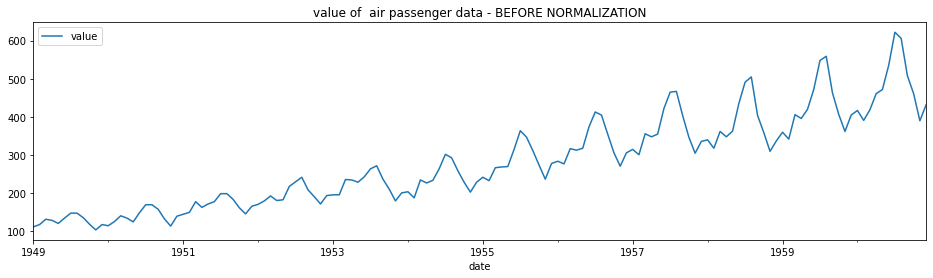

In [5]:
df.plot(figsize=(16,4),legend=True)

plt.title('value of  air passenger data - BEFORE NORMALIZATION')

plt.show()

- **Normalize data**
- Before proceeding with further data analysis we must ensure that the data is normalized. 
- For this we will be using [sklearn MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['value']=scaler.fit_transform(df['value'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(144, 1)

- **Visualize data after normalization**
- After normalization the range of power consumption values changes which we can observe on the **y-axis** of the graph. In the earlier graph that was displayed it was in the range **0 - 22500**
- Now after normalization we can observe that the data range on **y-axis** is **0.0 - 1.0**

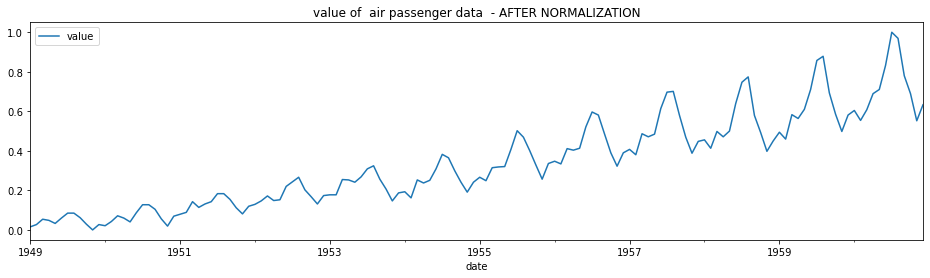

In [7]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('value of  air passenger data  - AFTER NORMALIZATION')

plt.show()

In [8]:
df_norm.shape

(144, 1)

## 3. Prepare data for training the RNN models

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[100:]             
    y_test = y_train[100:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:100]           
    y_train = y_train[:100]
   
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    print(X_train.shape)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (100, seq_len, 1))
    print(X_train.shape)
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

**To get an understanding on how sequence length is useful in training RNN models refer to the following links:**
- https://stackoverflow.com/questions/49573242/what-is-sequence-length-in-lstm
- https://stats.stackexchange.com/questions/158834/what-is-a-feasible-sequence-length-for-an-rnn-to-model

In [10]:
#create train, test data
seq_len = 4 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

(100, 4)
(100, 4, 1)
X_train.shape =  (100, 4, 1)
y_train.shape =  (100,)
X_test.shape =  (40, 4, 1)
y_test.shape =  (40,)


## 4. Build a SIMPLE RNN model

In [21]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 4, 40)             1680      
                                                                 
 dropout_6 (Dropout)         (None, 4, 40)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 4, 40)             3240      
                                                                 
 dropout_7 (Dropout)         (None, 4, 40)             0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [22]:
input_shape=(X_train.shape[1],1)
print(input_shape)

(4, 1)


In [23]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=10)

Epoch 1/10


10/10 [==============================] - 1s 2ms/step - loss: 0.0735
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0155


- **Let's check r2 score for the values predicted by the above trained SIMPLE RNN model**
- For more info on r2 score refer [this](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [24]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

2/2 [==============================] - 0s 2ms/step
R2 Score of RNN model =  0.2880215559125908


- **Let's compare the actual values vs predicted values by plotting a graph**
- We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

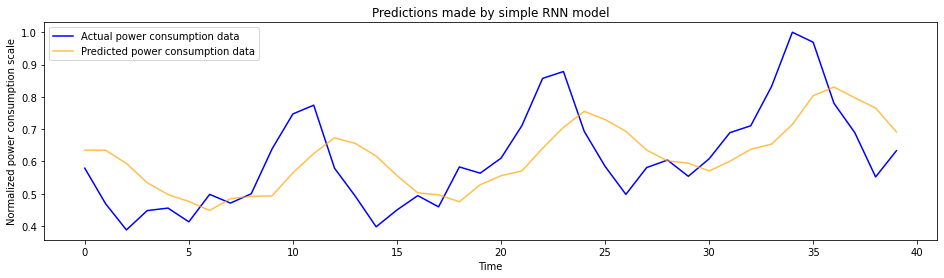

In [25]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

## 5. Build an LSTM model

In [26]:
lstm_model = Sequential()

lstm_model.add(LSTM(8,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(8,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(8,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4, 8)              320       
                                                                 
 dropout_9 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_4 (LSTM)               (None, 4, 8)              544       
                                                                 
 dropout_10 (Dropout)        (None, 4, 8)              0         
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [27]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=1000, batch_size=10)

Epoch 1/1000


10/10 [==============================] - 3s 3ms/step - loss: 0.0787
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0433
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0327
Epoch 5/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0282
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 7/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0227
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 10/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 11/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 12/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 13/1000
10/10 [=================

- **Let's check r2 score for the values predicted by the above trained LSTM model**

In [28]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

2/2 [==============================] - 1s 3ms/step
R^2 Score of LSTM model =  0.581188622404401


- **Let's compare the actual values vs predicted values by plotting a graph**

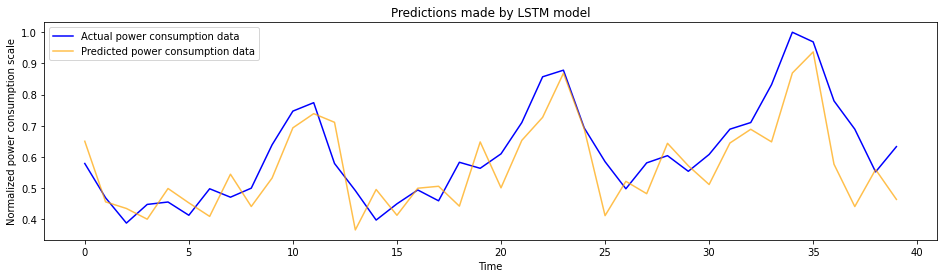

In [29]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

## 6. Compare predictions made by simple RNN, LSTM model by plotting data in a single graph

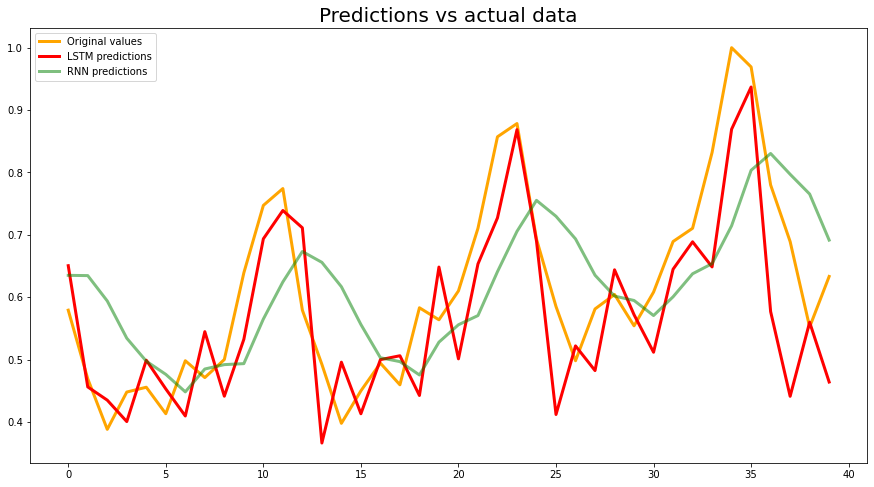

In [30]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()